# Draw pairs of mass and redshift according to a mass function (computed with either CCL or NumCosmo)

In [1]:
import sys
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy 
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock
%matplotlib inline

In [2]:
# NumCosmo imports
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

## Mass function - CCL implementation

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.26, Omega_b=0.04,
                      h=0.7, sigma8=0.8, n_s=0.96, Neff=3.04,  m_nu=1.0e-05, m_nu_type="single")
hmd_200c = ccl.halos.MassDef(200, 'critical') 
def tinker08_ccl(logm, z):
    mass = 10**(logm)
    hmf_200c = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)
    nm = hmf_200c.get_mass_function(cosmo, mass, 1./(1+z))
    return nm # dn/dlog10M

def dV_over_dOmega_dz(z):
    a = 1./(1. + z)
    da = ccl.background.angular_diameter_distance(cosmo, a) 
    E = ccl.background.h_over_h0(cosmo, a)
    return ((1.+z)**2)*(da**2)*ccl.physical_constants.CLIGHT_HMPC/cosmo['h']/E 

def pdf_tinker08_ccl(logm,z):
    return tinker08_ccl(logm, z)*dV_over_dOmega_dz(z)


## Mass function - Numcosmo implementation

In [4]:
Ncm.cfg_init ()
#cosmo_nc = Nc.HICosmoDEXcdm()
cosmo_nc = Nc.HICosmo.new_from_name(
    Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<1>}")
cosmo_nc.omega_x2omega_k()
cosmo_nc.param_set_by_name("w0", -1.0)
cosmo_nc.param_set_by_name("w1", 0.0)
cosmo_nc.param_set_by_name("Tgamma0", 2.725)
cosmo_nc.param_set_by_name("massnu_0", 0.0)
cosmo_nc.param_set_by_name("H0", 70.)
cosmo_nc.param_set_by_name("Omegab", 0.04)
cosmo_nc.param_set_by_name("Omegac", 0.26)
cosmo_nc.param_set_by_name("Omegak", 0.0)


# ENnu = 3.046 - 3.0 * \
#     cosmo_nc.E2Press_mnu(1.0e10) / (cosmo_nc.E2Omega_g(1.0e10)
#                                  * (7.0/8.0*(4.0/11.0)**(4.0/3.0)))

ENnu = 3.046
cosmo_nc.param_set_by_name("ENnu", ENnu)
reion = Nc.HIReionCamb.new () 
prim = Nc.HIPrimPowerLaw.new () 

cosmo_nc.add_submodel (reion)
cosmo_nc.add_submodel (prim)

dist = Nc.Distance.new (2.0)
dist.prepare_if_needed(cosmo_nc)
tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-6)
psml.require_kmax (1.0e3)

psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

prim.props.n_SA = 0.96

old_amplitude = np.exp (prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log ((0.8 / cosmo_nc.sigma8(psf))**2 * old_amplitude)
print(0.8, cosmo_nc.sigma8(psf))

mulf = Nc.MultiplicityFuncTinker.new ()
mulf.set_mdef (Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta (200.0)
mf = Nc.HaloMassFunction.new (dist, psf, mulf)
#
# New mass function object using the objects defined above.
#
def tinker08_nc(logm, z):
    lnm = logm * np.log(10.) # convert log10(M) to ln(M) 
    res = mf.dn_dlnM(cosmo_nc, lnm, z)
    return res * np.log(10.) # convert dn/dlnM to dn/dlog10M

def pdf_tinker08_nc(logm, z):
    return tinker08_nc(logm, z)*mf.dv_dzdomega(cosmo_nc, z)

0.8 0.8


## Compare the CCL and NC implementations

### Volume element

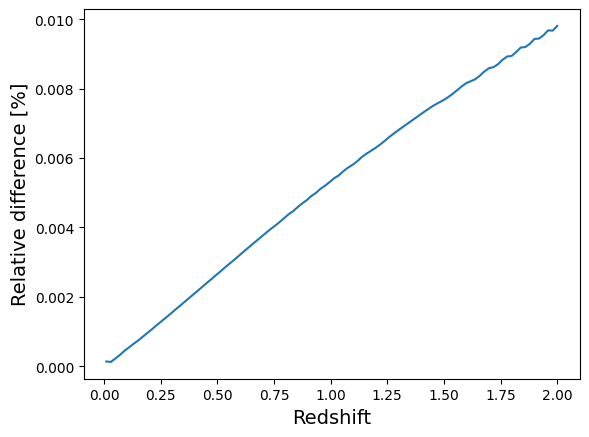

In [5]:
z_arr = np.linspace(0.01, 2, 100)
v_nc = [mf.dv_dzdomega(cosmo_nc, z) for z in z_arr]
v_ccl = dV_over_dOmega_dz(z_arr)
plt.plot(z_arr, np.abs(v_nc/v_ccl -1)*100);
plt.xlabel('Redshift', size=14);
plt.ylabel('Relative difference [%]', size=14);

### Mass function

The CCL and Numcosmo implementations give different results for the Tinker08 HMF, especially at high redshift (>1.5). Need to understand why, although it is not a regime we should find ourselves in with cluster studies at optical wavelength. Might be that the CCL and NC cosmologies defined above are not actually the same (neutrinos?).

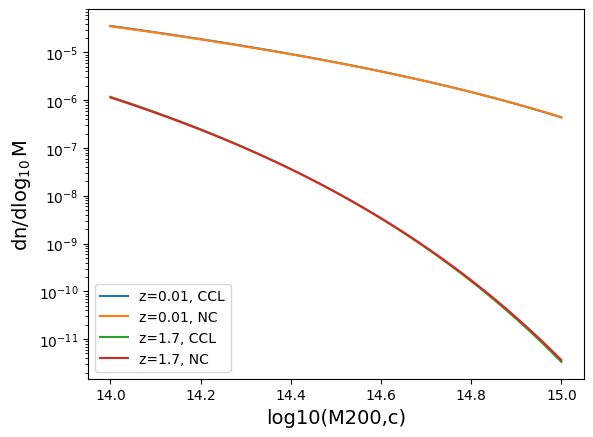

In [6]:
logm_arr=np.linspace(14.,15)
z_arr = np.linspace(0.01, 1.7, 2)

t08_vec_ccl=np.vectorize(tinker08_ccl)
t08_vec_nc=np.vectorize(tinker08_nc)
for z in z_arr:
    res_ccl = t08_vec_ccl(logm_arr,z)
    res_nc = t08_vec_nc(logm_arr,z)
    plt.plot(logm_arr, res_ccl, label=f'z={z}, CCL');
    plt.plot(logm_arr, res_nc, label=f'z={z}, NC');
    plt.yscale('log');
    plt.xlabel('log10(M200,c)', size=14);
    plt.ylabel('dn/d$\log_{10}$M', size=14);
plt.legend();

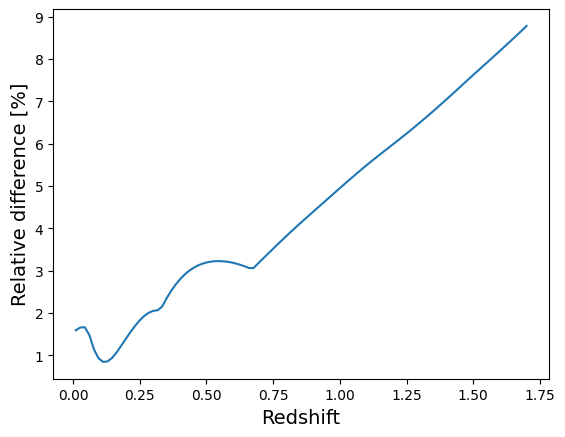

In [7]:
z_arr = np.linspace(0.01, 1.7, 100)
logm = 15.
res_ccl = t08_vec_ccl(logm,z_arr)
res_nc = t08_vec_nc(logm,z_arr)
plt.plot(z_arr, np.abs(res_ccl/res_nc -1)*100);
plt.xlabel("Redshift", size=14);
plt.ylabel("Relative difference [%]", size=14);

## Acceptance-rejection method to sample (M,z) from the mass function

In [8]:
def bivariate_draw(pdf, N=1000,logm_min=14.,logm_max=15., zmin=0.01, zmax=1, Ngrid_m=30, Ngrid_z=30):  
    """  
    Uses the rejection method for generating random numbers derived from an arbitrary   
    probability distribution. 

    Parameters
    ----------
    pdf : func
      2d distribution function to sample
    N : int
      number of points to generate  
    log_min,logm_max : float 
      log10 mass range  
    zmin,zmax : float 
      redshift range  

    Returns:   
    --------
    ran_logm : list
        accepted logm values  
    ran_z : list
        accepted redshift values
    acceptance : float
        acceptance ratio of the method
    """  

    # maximum value of the pdf over the mass and redshift space.
    # the pdf is not monotonous in mass and redshift, so we need
    # to find the maximum numerically. Here we scan the space
    # with a regular grid and use the maximum value.
    # Accuracy of the results depends on Ngrid_m and Ngrid_z 
    # This should probably be improved
    
    logM_arr = np.linspace(logm_min, logm_max, Ngrid_m)  
    z_arr = np.logspace(np.log10(zmin), np.log10(zmax), Ngrid_z)  
    p = []
    for logM in logM_arr:
        for z in z_arr:
            p.append(pdf(logM, z))  
    pmax = np.max(p)
    pmin = np.min(p)
    # Counters  
    naccept = 0  
    ntrial = 0  

    # Keeps drawing until N points are accepted  
    ran_logm = [] # output list of random numbers  
    ran_z = [] # output list of random numbers  
    while naccept < N:  
        # draw (logm,z) from uniform distribution
        # draw p from uniform distribution
        logm = np.random.uniform(logm_min,logm_max) # x'  
        z = np.random.uniform(zmin,zmax) # x'  
        p = np.random.uniform(pmin,pmax) # y'  

        if p < pdf(logm, z):  
            # keep the point
#            print(logm, z, p, pdf(logm, z))
            ran_logm.append(logm)  
            ran_z.append(z)  
            naccept = naccept+1  
        ntrial = ntrial+1  

    ran_logm = np.asarray(ran_logm)  
    ran_z = np.asarray(ran_z)  

    acceptance = float(N/ntrial)
    print(f"acceptance = {acceptance}")
    return ran_logm, ran_z, acceptance

## Draw (M,z) pairs and check consistency with mass function

In [9]:
# Define the numbers of pairs to draw and the mass and redshift ranges
N = 50
logm_min = 14.
logm_max = 14.5
zmin = 0.2
zmax = 1.

# Choose between the CCL and NC implementation (NC is faster)
#pdf = pdf_tinker08_ccl
pdf = pdf_tinker08_nc

In [10]:
# Normalisation factor for the pdf to be used later
norm = 1./scipy.integrate.dblquad(pdf, zmin, zmax, lambda x:logm_min, lambda x:logm_max, epsrel=1.e-4)[0]

In [11]:
# Random draw
ran_logm, ran_z, acceptance = bivariate_draw(pdf, N=N,logm_min=logm_min,logm_max=logm_max, zmin=zmin, zmax=zmax)

acceptance = 0.32051282051282054


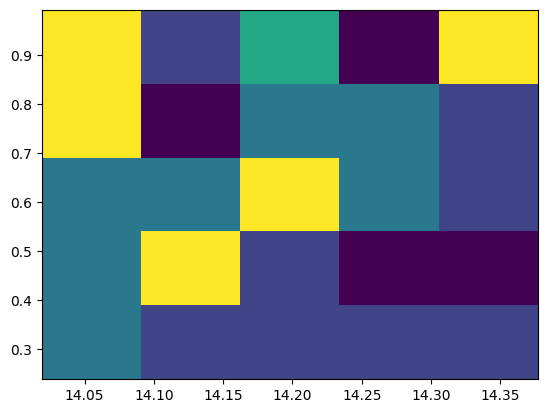

In [12]:
plt.hist2d(ran_logm, ran_z, bins=5);

## Check distribution in mass bins (integrate over the full redshift range)

[14.01906948 14.05485744 14.09064541 14.12643338 14.16222134 14.19800931
 14.23379728 14.26958524 14.30537321 14.34116118 14.37694914]


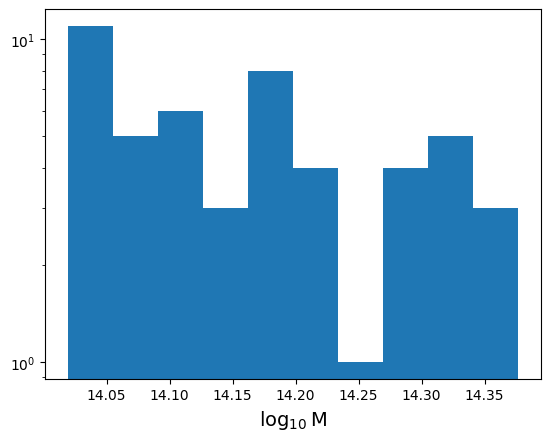

In [13]:
hist_m = plt.hist(ran_logm, bins=10);
plt.yscale('log');
plt.xlabel('$\log_{10}$M', size=14);
print(hist_m[1])

In [14]:
print(zmin, zmax)
predicted_T08_m_quad=[]
for i in np.arange(len(hist_m[0])):
    lmmin = hist_m[1][i]
    lmmax = hist_m[1][i+1]
    N_T08 =  norm * N * scipy.integrate.dblquad(pdf, zmin, zmax, lambda x:lmmin, lambda x:lmmax, epsrel=1.e-4)[0]
    predicted_T08_m_quad.append(N_T08) 


0.2 1.0


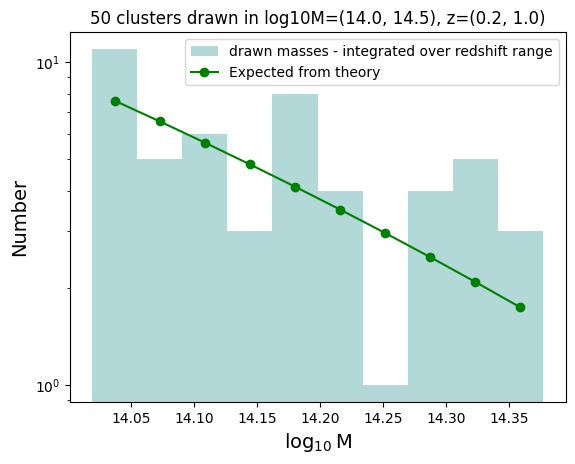

In [15]:
bin_centers_m=[(hist_m[1][i]+hist_m[1][i+1])/2. for i in np.arange(len(hist_m[0]))]

hist_m = plt.hist(ran_logm, bins=10, color='teal', alpha=0.3, label='drawn masses - integrated over redshift range');
plt.plot(bin_centers_m,np.array(predicted_T08_m_quad), '-o',color='green', label='Expected from theory');
plt.yscale('log');
plt.xlabel('$\log_{10}$M', size=14);
plt.ylabel('Number', size=14);
plt.title(f'{N} clusters drawn in log10M={logm_min, logm_max}, z={zmin, zmax}');
plt.legend();

## Check distribution in redshift bins (integrate over the full mass range)

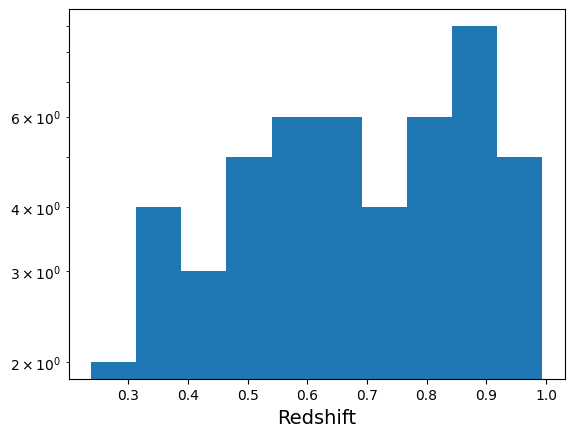

In [16]:
hist_z = plt.hist(ran_z, bins=10);
plt.yscale('log');
plt.xlabel('Redshift', size=14);

In [17]:
print(logm_min, logm_max)
predicted_T08_z_quad=[]
for i in np.arange(len(hist_z[0])):
    zzmin = hist_z[1][i] 
    zzmax = hist_z[1][i+1]
    N_T08 = norm * N * scipy.integrate.dblquad(pdf, zzmin, zzmax, lambda x:logm_min, lambda x:logm_max, epsabs=1.e-4, epsrel=1.e-4)[0]
    predicted_T08_z_quad.append(N_T08) 


14.0 14.5


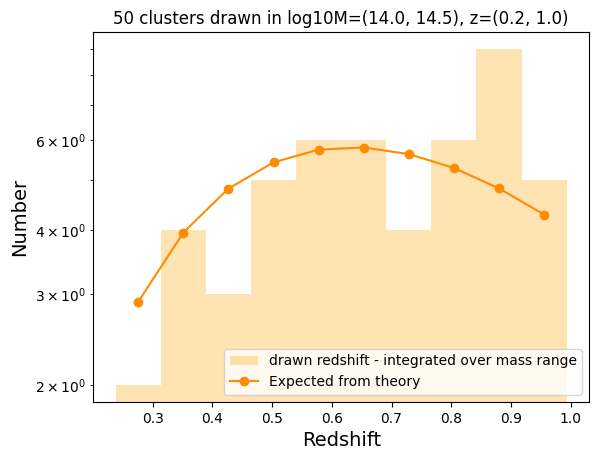

In [18]:
bin_centers_z=[(hist_z[1][i]+hist_z[1][i+1])/2. for i in np.arange(len(hist_z[0]))]

hist_z = plt.hist(ran_z, bins=10, color='orange', alpha=0.3, label='drawn redshift - integrated over mass range');
plt.plot(bin_centers_z,np.array(predicted_T08_z_quad), '-o',color='darkorange', label='Expected from theory');
plt.yscale('log');
plt.xlabel('Redshift', size=14);
plt.ylabel('Number', size=14);
plt.title(f'{N} clusters drawn in log10M={logm_min, logm_max}, z={zmin, zmax}');
plt.legend(loc=4);

## Generating a cluster catalog and associated source catalogs
Before we generate the cluster catalog, we have to compute each cluster concentration and define the clusters center. Beblow we follow the steps:
- First we will set the cluster masses and redshifts given the generated mock data. 
- Than we need a concentration object to compute the concentration for each cluster and store in a list. Since the actual concentration for each cluster can be given by a caussian centered in the mean value, which is the one calculated, we recompute each cluster's concentration trough a normal distribution centered on the theoretical value with a dispersion of 0.14.
- Last, we randomly generate the cluster center coordinates from 0 to 360 deg for ra and from -90 to 90 deg to dec.

In [19]:
cluster_m = 10 **ran_logm
cluster_z =  ran_z
#Concentration CCL object to compute the theoretical concentration
conc_obj = ccl.halos.ConcentrationDuffy08(hmd_200c)
conc_list = []
for number in range (0, len(cluster_m)):
    a = 1./(1. + (cluster_z[number]))
    theoretical_c = conc_obj.get_concentration(cosmo, M = (cluster_m[number]),a = a)
#Generating gaussians centered on the theoretical concentration values to generate scattered concentrations
    normal_c = np.random.normal(theoretical_c, 0.14)
    conc_list.append(normal_c)  
    
conc_list  = np.array(conc_list)


# randomly draw cluster positions on the sky
ra = np.random.random(N) * 360 #from 0 to 360 deg
sindec = np.random.random(N) * 2 - 1
dec = np.arcsin(sindec) * 180 / np.pi #from -90 to 90 deg

### Background galaxy catalog generation

For each cluster of the ensemble, we use `mock_data` to generate a background galaxy catalog and store the results in a `GalaxyCluster` object. Note that:
- The cluster density profiles follow the NFW parametrisation;
- The source redshifts follow the Chang et al. distribution and have associated pdfs;
- The shapes include shape noise and shape measurement errors;
- Background galaxy catalogs are independent, even if the clusters are close (i.e., no common galaxy between two catalogs).
- For each cluster we then compute
    - the tangential and cross $\Delta\Sigma$ for each background galaxy
    - the weights `w_ls` to be used to compute the corresponding radial profiles (see `demo_compute_deltasigma_weights.ipynb` notebook for details)

The cluster objects are then stored in `gclist`.

In [20]:
gclist = []
# number of galaxies in each cluster field (alternatively, can use the galaxy density instead)
n_gals = 10000
#ngal_density = 10
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
#cosmo_clmm.set_be_cosmo(cosmo)
for i in range(N):
    # generate background galaxy catalog for cluster i
    noisy_data_z = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], conc_list[i], cosmo_clmm, 
                                                cluster_ra=ra[i], cluster_dec=dec[i],
                                                zsrc = 'chang13', 
                                                delta_so=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min= cluster_z[i] + 0.1,
                                                zsrc_max=3.0, 
                                                field_size=10., 
                                                shapenoise=.04, 
                                                photoz_sigma_unscaled=0.02, 
                                                ngals=n_gals,
                                                mean_e_err=.1)

    cl = clmm.GalaxyCluster('mock_cluster', ra[i], dec[i], cluster_z[i], noisy_data_z)

    # compute DeltaSigma for each background galaxy
    cl.compute_tangential_and_cross_components(shape_component1='e1', shape_component2='e2', 
                                               tan_component='DS_t', cross_component='DS_x',
                                               cosmo=cosmo_clmm, is_deltasigma=True, use_pdz=True)
    
    # compute the weights to be used to bluid the DeltaSigma radial profiles
    cl.compute_galaxy_weights(use_pdz = True,
    use_shape_noise = True, shape_component1 = 'e1', shape_component2 = 'e2', 
    use_shape_error = True, shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    weight_name = 'w_ls', cosmo = cosmo_clmm, is_deltasigma = True, add = True)

    # append the cluster in the list
    gclist.append(cl)

/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/usr/local/lib/python3.8/dist-packages/clmm-1.4.0-py3.8.egg/clmm/utils.py:641: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galax

In [21]:
cl.galcat.columns

<TableColumns names=('ra','dec','e1','e2','e_err','z','ztrue','pzbins','pzpdf','id','sigma_c','theta','DS_t','DS_x','w_ls')>

## Creating ClusterEnsemble object and estimation of individual excess surface density profiles
From the galaxy cluster object list `gclist`, we instantiate a cluster ensemble object `clusterensemble`. This instantiation step uses
 - the individual galaxy input $\Delta\Sigma_+$ and $\Delta\Sigma_{\times}$ values (computed in the previous step, `DS_{t,x}`)
 - the corresponding individual input weights `w_ls` (computed in the previous step)

to compute

- the output tangential `DS_t` and cross signal `DS_x` binned profiles (where the binning is controlled by `bins`)
- the associated profile weights `W_l` (that will be used to compute the stacked profile)

In [22]:
ensemble_id = 1
names = ['id', 'ra', 'dec', 'z', 'radius', 'gt', 'gx', 'W_l']
bins = np.logspace(np.log10(0.3),np.log10(5),10)
clusterensemble = ClusterEnsemble(ensemble_id, gclist, 
                                  tan_component_in='DS_t', cross_component_in='DS_x', 
                                  tan_component_out='DS_t', cross_component_out='DS_x', 
                                  weights_in = 'w_ls', weights_out = 'W_l', 
                                  bins=bins, bin_units='Mpc', cosmo=cosmo_clmm)

## Stacked profile of the cluster ensemble
The stacked radial profile of the ensemble is then obtained as 

In [23]:
clusterensemble.make_stacked_radial_profile(tan_component='DS_t', cross_component='DS_x')

## Covariance (Bootstrap, sample, Jackknife) of the stack between radial bins
Radial bins may be correlated and the `ClusterEnsemble` class provides three methods to compute the covariance matrix of the stacked signal, from the data:
- The Sample covariance directly computes the covariance between radial bins of the `N` individual cluster profiles of the stack.
- The Bootstrap approach is a resampling technique generating `n_bootstrap` ensembles of `N` randomly drawn clusters from the original ensemble, allowing for duplication. For each new ensemble, the stacked profile is computed and the covariance computed over the `n_bootstrap` stacks.
- The Jackknife approach is another resampling technique, that divides the sky in a given number of regions $N_{\rm region}$ and computes the covariance removing one region (i.e the clusters of the ensemble in that region) at a time. The stack is then computed using the remaining clusters and the covariance computed over the $N_{\rm region}$ number of stacks. The division of the sky is done using the Healpix pixelisation scheme and is controlled by the `n_side` parameter, with $N_{\rm region}=12 N_{\rm side}^2$.

NB: Approaches exist to compute the theoretical covariance of a stack but these are not (yet) available in `CLMM`

In [24]:
clusterensemble.compute_sample_covariance(tan_component='DS_t', cross_component='DS_x')
clusterensemble.compute_bootstrap_covariance(tan_component='DS_t', cross_component='DS_x', n_bootstrap=300)
clusterensemble.compute_jackknife_covariance(n_side=16,tan_component='DS_t', cross_component='DS_x')

[]

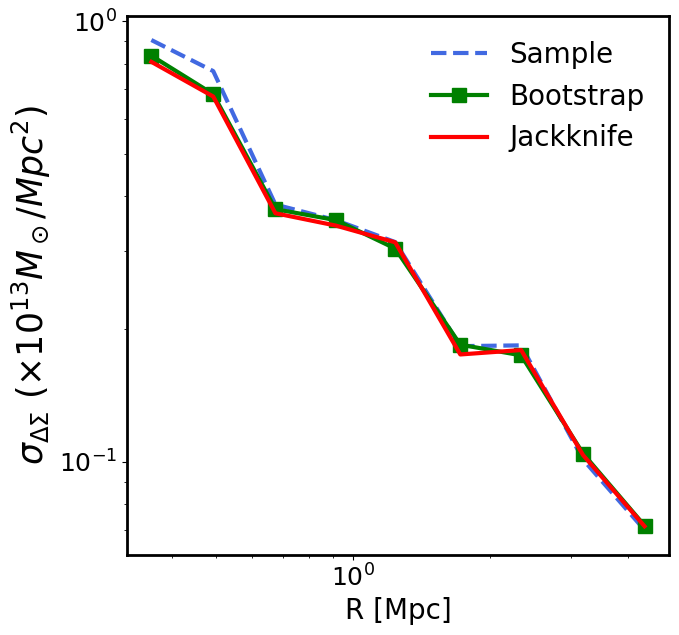

In [25]:
plt.figure(figsize = (7,7))
plt.rcParams['axes.linewidth'] = 2
plt.plot(clusterensemble.data['radius'][0], clusterensemble.sample_tangential_covariance.diagonal()**0.5/1e13,'--',c = 'royalblue', label = 'Sample', linewidth = 3)
plt.plot(clusterensemble.data['radius'][0], clusterensemble.bootstrap_tangential_covariance.diagonal()**0.5/1e13,'-s',c = 'g', label = 'Bootstrap', linewidth = 3, markersize = 10)
plt.plot(clusterensemble.data['radius'][0], clusterensemble.jackknife_tangential_covariance.diagonal()**0.5/1e13,c = 'r', label = 'Jackknife', linewidth = 3)
plt.xlabel('R [Mpc]', fontsize =20)
plt.ylabel(r'$\sigma_{\Delta\Sigma}\ (\times 10^{13} M_\odot /Mpc^2)$', fontsize =25)
plt.tick_params(axis='both', which = 'major', labelsize= 18)
plt.legend(frameon = False, fontsize = 20)
plt.loglog()

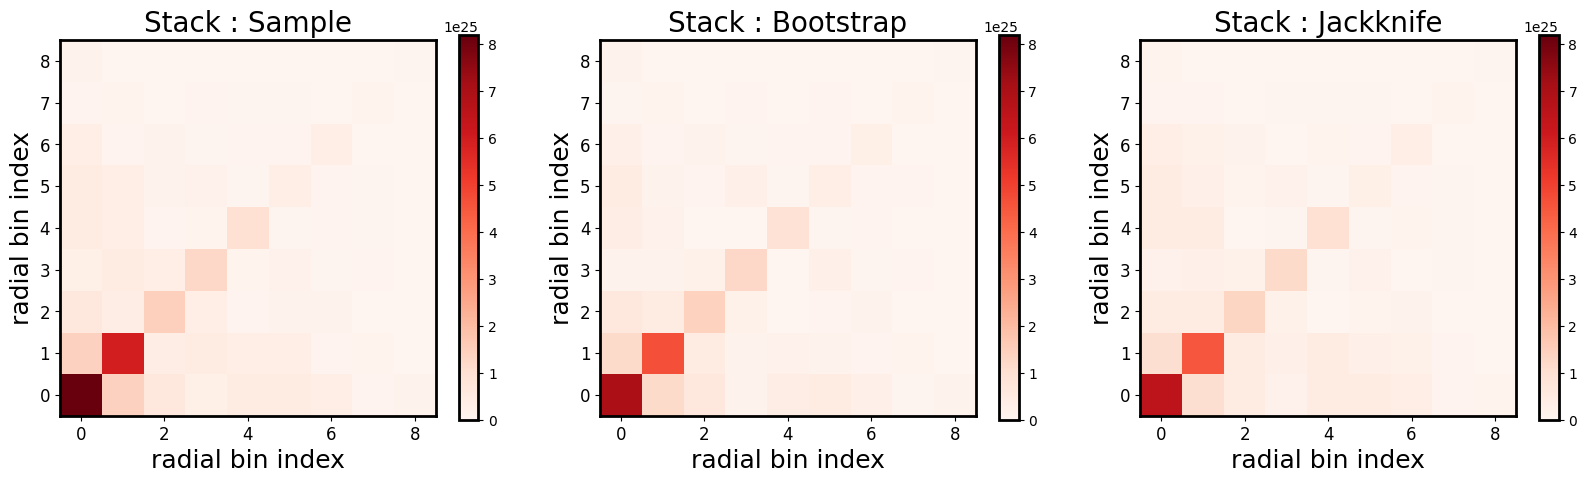

In [26]:
fig, ax = plt.subplots(1,3, figsize =(20, 5))
plt.rcParams['axes.linewidth'] = 2
fig.subplots_adjust(wspace=0.15, hspace=0)
cov = [clusterensemble.sample_tangential_covariance, 
       clusterensemble.bootstrap_tangential_covariance,
       clusterensemble.jackknife_tangential_covariance]
maximum = max(clusterensemble.sample_tangential_covariance.flatten())
label = ['Stack : Sample', 'Stack : Bootstrap', 'Stack : Jackknife']
for i in range(3):
    ax[i].set_title(label[i], fontsize = 20)
    ax[i].set_xlabel('radial bin index', fontsize = 18)
    ax[i].set_ylabel('radial bin index', fontsize = 18)
    ax[i].tick_params(axis='both', which = 'major', labelsize= 12)
    im = ax[i].imshow(cov[i], cmap = 'Reds',vmin = 0, vmax = maximum, origin = 'lower')
    plt.colorbar(im, ax=ax[i])

## Visualizing the stacked profiles and corresponding model
In the figure below, we plot:
- the individual $\Delta\Sigma$ profiles of the clusters (light blue)
- the stacked signal (red symbols)
- the prediction computed using a NFW profile and the mean values of the mass, concentration and redshift in the stack (dashed black)

In [27]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)
# Average values of mass and concentration of the ensemble to be used below to overplot the model on the stacked profile
moo.set_concentration(conc_list.mean())
moo.set_mass(cluster_m.mean())

[11.47612267  9.04112332  6.82703637  5.00564483  3.5675923   2.37838938
  1.58271575  1.02054493  0.64653582]


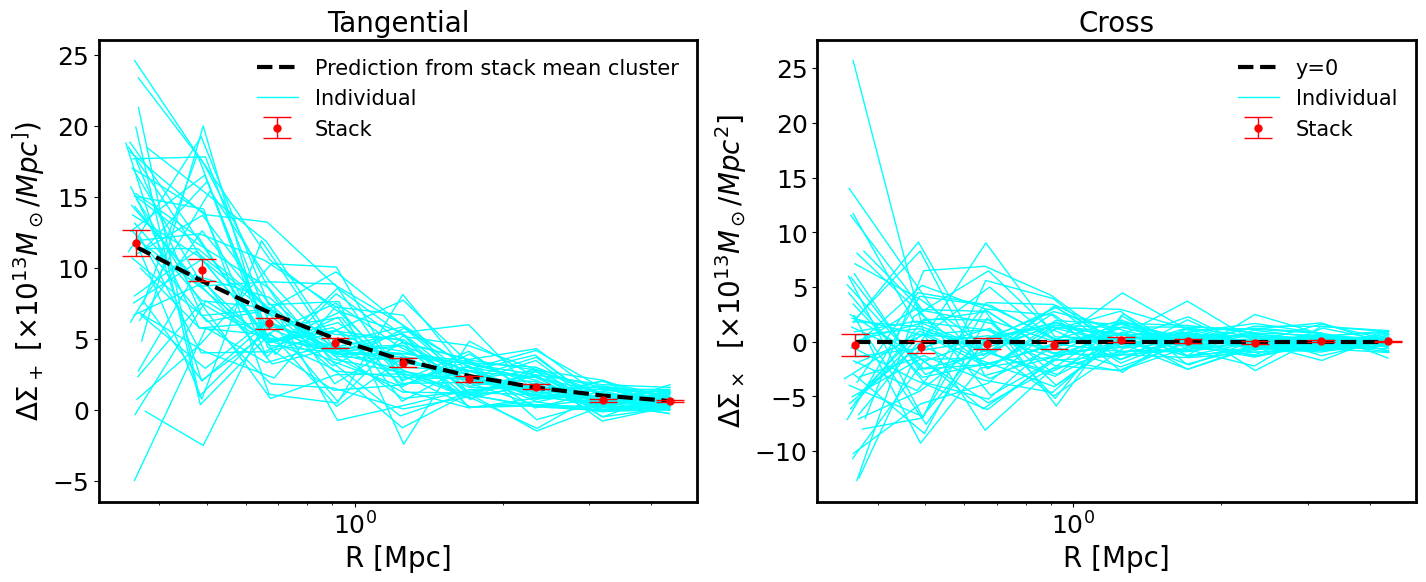

In [28]:
r_stack, gt_stack, gx_stack = (clusterensemble.stacked_data[c] for c in ('radius', 'DS_t', 'DS_x'))
plt.rcParams['axes.linewidth'] = 2
fig, axs = plt.subplots(1,2, figsize = (17,6))

err_gt = clusterensemble.sample_tangential_covariance.diagonal()**0.5/1e13
err_gx = clusterensemble.sample_cross_covariance.diagonal()**0.5/1e13

axs[0].errorbar(r_stack,gt_stack/1e13, err_gt,markersize = 5, c = 'r', fmt = 'o', capsize = 10, elinewidth = 1, zorder = 1000, alpha = 1, label = 'Stack')
axs[1].errorbar(r_stack,gx_stack/1e13, err_gx,markersize = 5, c = 'r', fmt = 'o', capsize = 10, elinewidth = 1, zorder = 1000, alpha = 1, label = 'Stack')
print(moo.eval_excess_surface_density(clusterensemble.data['radius'][0], cluster_z.mean())/1e13)
axs[0].plot(clusterensemble.data['radius'][0],moo.eval_excess_surface_density(clusterensemble.data['radius'][0], cluster_z.mean())/1e13, '--k', linewidth = 3, label = 'Prediction from stack mean cluster', zorder = 100)
axs[1].plot(clusterensemble.data['radius'][0],0*moo.eval_excess_surface_density(clusterensemble.data['radius'][0], cluster_z.mean())/1e13, '--k', linewidth = 3, label = 'y=0', zorder = 100)

axs[0].set_xscale('log')
axs[1].set_xscale('log')


for i in range(N):
    axs[0].plot(clusterensemble.data['radius'][i],clusterensemble.data['DS_t'][i]/1e13,color='cyan', label = 'Individual', alpha = 1, linewidth = 1)
    axs[1].plot(clusterensemble.data['radius'][i],clusterensemble.data['DS_x'][i]/1e13, color='cyan', label = 'Individual', alpha = 1, linewidth = 1)
    if i == 0:
        axs[0].legend(frameon = False, fontsize = 15)
        axs[1].legend(frameon = False, fontsize = 15)
#axs[0].plot(np.average(clusterensemble.data['radius'], axis = 0), np.average(clusterensemble.data['gt'], weights = None, axis = 0)/1e13)
axs[0].set_xlabel('R [Mpc]', fontsize =20)
axs[1].set_xlabel('R [Mpc]', fontsize =20)
axs[0].tick_params(axis='both', which = 'major', labelsize= 18)
axs[1].tick_params(axis='both', which = 'major', labelsize= 18)
axs[0].set_ylabel(r'$\Delta\Sigma_+$ $[\times 10^{13} M_\odot /Mpc^])$', fontsize= 20)
axs[1].set_ylabel(r'$\Delta\Sigma_\times$  $[\times 10^{13} M_\odot /Mpc^2]$', fontsize= 20)
axs[0].set_title(r'Tangential', fontsize= 20)
axs[1].set_title(r'Cross', fontsize= 20)

plt.show()
